# Predicting Collision Cross Section values

Recently, ion mobility–mass spectrometry (IM–MS) has emerged as a promising technique for untargeted metabolomics by providing multi-dimensional separation and high selectivity. Ion mobility can rapidly separate metabolite ions based on their differences in rotationally averaged surface area or collision cross-section (CCS) The collision cross section is defined as the area around a particle in which the center of another particle must be in order for a collision to occur.

In this notebook, we will use a deep learning approach to predict CCS values.

References:
> - [Zhou Z. et al (2020): Ion mobility collision cross-section atlas for known and unknown metabolite annotation in untargeted metabolomics](https://www.nature.com/articles/s41467-020-18171-8)
> - [Chemistry Liretexts: Collisional Cross Section](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Kinetics/06%3A_Modeling_Reaction_Kinetics/6.01%3A_Collision_Theory/6.1.01%3A_Collisional_Cross_Section#:~:text=The%20collisional%20cross%20section%20is%20defined%20as%20the%20area%20around,molecule%20A's%20collisional%20cross%20section)

In [1]:
## IPython extension to reload modules before executing user code.
# Autorelad is an IPython extension to reload modules before executing user code.
%load_ext autoreload

# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [ ]:
!pip install rdkit

In [2]:
import os
import sys

ROOT_DIR = os.sep.join(os.path.abspath('.').split(os.sep)[:-1])
sys.path.insert(0, ROOT_DIR)
DATASET_DIR = "{}/data".format(ROOT_DIR)
print("ROOT_DIR: {}".format(ROOT_DIR))
print("DATASET_DIR: {}".format(DATASET_DIR))

from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re


from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit.Chem.inchi import MolFromInchi
from rdkit.Chem import PandasTools, MolFromSmiles, AllChem, MolFromSmiles, Draw, MolToInchiKey, MolToSmiles
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages




from sklearn.preprocessing import StandardScaler, FunctionTransformer, scale

import torch
import torch.nn as nn
import torch.nn.functional as F # contains functional interface of typical operations used for building nn's
import torch.optim as optim     # contains optimizers e.g. Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
# from torchmetrics import ConfusionMatrix, Accuracy
# from tqdm import tqdm
from torch.nn import functional as F

# from lib import utilities
from lib.utilities import *

# import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

torch.set_printoptions(linewidth=120)

import warnings
warnings.filterwarnings("ignore")



ROOT_DIR: /home/jovyan/projects/djoy4stem_github/ccs_prediction
DATASET_DIR: /home/jovyan/projects/djoy4stem_github/ccs_prediction/data


In [3]:
SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Data Collection
The data was downloaded from the Unified CCS Compendium website. The entire database was downloaded from the **Compound Table** page as a .csv file, which we will use to train adduct-dependent ccs values.
>- [Unified CCS Compendium](https://mcleanresearchgroup.shinyapps.io/CCS-Compendium/)

In [4]:
ccs_data = pd.read_csv("{}/UnifiedCCSCompendium_FullDataSet_2022-08-23.csv".format(DATASET_DIR))
ccs_data.head()

,Compound,Neutral.Formula,CAS,InChi,InChiKey,Theoretical.mz,mz,Ion.Species,Ion.Species.Agilent,Charge,...,Rep5,Rep6,Rep7,Rep8,Rep9,Rep10,Rep11,Rep12,Rep13,Rep14
0,Nicotinamide Hypoxanthine Dinucleotide,C21H26N6O15P2,104809-38-3,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,DGVSIBCCYUVRNA-NNYOXOHSSA-O,685.0672,685.0673,[M-2H+Na],(M-2H+Na)-,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nicotinamide Hypoxanthine Dinucleotide,C21H26N6O15P2,104809-38-3,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,DGVSIBCCYUVRNA-NNYOXOHSSA-O,663.0853,663.0855,[M-H],(M-H)-,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nicotinamide Hypoxanthine Dinucleotide,C21H26N6O15P2,1851-07-6,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,DGVSIBCCYUVRNA-NNYOXOHSSA-O,665.1009,665.0966,[M+H],(M+H)+,1,...,222.56,220.83,220.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nicotinamide Hypoxanthine Dinucleotide,C21H26N6O15P2,1851-07-6,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,DGVSIBCCYUVRNA-NNYOXOHSSA-O,687.0829,687.0784,[M+Na],(M+Na)+,1,...,230.13,230.84,230.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NADPH,C21H30N7O17P3,2646-71-1,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,ACFIXJIJDZMPPO-NNYOXOHSSA-N,744.0833,744.0837,[M-H],(M-H)-,-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ccs_data["Ion.Species"].value_counts()

[M+H]            908
[M-H]            887
[M+Na]           807
[M+K]            116
[M-2H+Na]        111
                ... 
[2M+H-2H2O]        1
[2M+H-H2O]         1
[M-H-CO2]-         1
[2M-H]-            1
[M+H-H2O-NH3]      1
Name: Ion.Species, Length: 78, dtype: int64

In [6]:
target = "CCS"
ccs_data = ccs_data[[target, "InChi", "Ion.Species"]].dropna()  ## [ccs_data["Ion.Species"]=="[M+H]"]
print(ccs_data.info())
ccs_data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 0 to 3727
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CCS          2731 non-null   float64
 1   InChi        2731 non-null   object 
 2   Ion.Species  2731 non-null   object 
dtypes: float64(1), object(2)
memory usage: 85.3+ KB
None


,CCS,InChi,Ion.Species
0,217.2,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M-2H+Na]
1,217.7,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M-H]
2,221.4,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M+H]
3,230.5,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M+Na]
4,246.7,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,[M-H]


In [7]:
smiles_column   = "SMILES"
molecule_column = "RMol"
ccs_data[molecule_column] = ccs_data["InChi"].apply(lambda x: MolFromInchi(x, removeHs=False))
ccs_data[smiles_column] = ccs_data[molecule_column].apply(lambda m: MolToSmiles(m, isomericSmiles=True) if m != None else None)
ccs_data["CanonicalSMILES"] = ccs_data[molecule_column].apply(lambda m: MolToSmiles(m, canonical=True) if m != None else None)
ccs_data = ccs_data.dropna(axis=0)
print(ccs_data.info())
ccs_data.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2703 entries, 0 to 3727
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CCS              2703 non-null   float64
 1   InChi            2703 non-null   object 
 2   Ion.Species      2703 non-null   object 
 3   RMol             2703 non-null   object 
 4   SMILES           2703 non-null   object 
 5   CanonicalSMILES  2703 non-null   object 
dtypes: float64(1), object(5)
memory usage: 147.8+ KB
None


,CCS,InChi,Ion.Species,RMol,SMILES,CanonicalSMILES
0,217.2,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M-2H+Na],"<img data-content=""rdkit/molecule"" src=""data:i...",[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...,[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...
1,217.7,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M-H],"<img data-content=""rdkit/molecule"" src=""data:i...",[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...,[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...
2,221.4,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M+H],"<img data-content=""rdkit/molecule"" src=""data:i...",[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...,[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...
3,230.5,InChI=1S/C21H26N6O15P2/c22-17(32)9-2-1-3-26(4-...,[M+Na],"<img data-content=""rdkit/molecule"" src=""data:i...",[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...,[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...
4,246.7,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,[M-H],"<img data-content=""rdkit/molecule"" src=""data:i...",[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...,[H][C@@]1(O)[C@@]([H])(COP(=O)(O)OP(=O)(O)OC[C...


### Dealing with replicated measurements

In [8]:
smiles_list = ccs_data[smiles_column].values.tolist()
print("# Measurements: {}".format(ccs_data.shape[0]))
print("# unique SMILES: {}".format(len(list(set(ccs_data[smiles_column].values.tolist())))))

# find duplicate entries
counts = [smiles_list.count(x) for x in smiles_list]
count_hash = dict(zip(smiles_list,counts))
# len(count_hash), len(counts), ccs_data[ccs_data[smiles_column] == smiles_list[0]][smiles_column]
counter = 0
duplicates = []
for i in count_hash:    
    if count_hash[i]>1:
#         print("{}: {} - {}".format(counter, i, count_hash[i]))
        duplicates.append(i)
    counter += 1
print("# SMILES with replicates: {}".format(len(duplicates)))

# Measurements: 2703
# unique SMILES: 1200
# SMILES with replicates: 713


#### Let's average the replicated values 
Here we'll assume there is no significantly large discrepancies between meadured CCS values for the same compounds. A stricter way would be to group those by a combination **SMILES strings** AND **Ion species**, remove in-group outliers, and average the remaining values.

In [10]:
ccs_data = average_duplicate_values(ccs_data[[smiles_column, molecule_column, "Ion.Species", "CanonicalSMILES", target]], group_by_cols=[smiles_column, "Ion.Species"], cols_to_average=[target])
print(ccs_data.info())
ccs_data[ccs_data["num_samples"]>1].head(10)

(2703, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2703 entries, 350 to 1840
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMILES           2703 non-null   object 
 1   RMol             2703 non-null   object 
 2   Ion.Species      2703 non-null   object 
 3   CanonicalSMILES  2703 non-null   object 
 4   CCS              2703 non-null   float64
 5   CCS_AVG          2703 non-null   float64
 6   CCS_stdev        420 non-null    float64
 7   CCS_min          2703 non-null   float64
 8   CCS_max          2703 non-null   float64
 9   CCS_median       2703 non-null   float64
 10  num_samples      2703 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 253.4+ KB
None


,SMILES,RMol,Ion.Species,CanonicalSMILES,CCS,CCS_AVG,CCS_stdev,CCS_min,CCS_max,CCS_median,num_samples
2096,C=C(OP(=O)(O)O)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+Na],C=C(OP(=O)(O)O)C(=O)O,138.1,138.10,0.000,138.1,138.1,138.10,2
2100,C=C(OP(=O)(O)O)C(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+Na],C=C(OP(=O)(O)O)C(=O)O,138.1,138.10,0.000,138.1,138.1,138.10,2
2925,CCC(C)C(N)C1=NC(C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+3H],CCC(C)C(N)C1=NC(C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)...,445.5,463.20,25.032,445.5,480.9,463.20,2
2926,CCC(C)C(N)C1=NC(C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+3H],CCC(C)C(N)C1=NC(C(O)=NC(CC(C)C)C(O)=NC(CCC(=O)...,480.9,463.20,25.032,445.5,480.9,463.20,2
2695,CCC(C)C(N=C(O)CN)C(O)=NCC(O)=NC(C)C(O)=NC(C(O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+5H],CCC(C)C(N=C(O)CN)C(O)=NCC(O)=NC(C)C(O)=NC(C(O)...,812.0,830.70,26.446,812.0,849.4,830.70,2
2696,CCC(C)C(N=C(O)CN)C(O)=NCC(O)=NC(C)C(O)=NC(C(O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+5H],CCC(C)C(N=C(O)CN)C(O)=NCC(O)=NC(C)C(O)=NC(C(O)...,849.4,830.70,26.446,812.0,849.4,830.70,2
2914,CCC(C)CCCCC(O)=NC(CCN)C(O)=NC(C(O)=NC(CCN)C(O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+H+K],CCC(C)CCCCC(O)=NC(CCN)C(O)=NC(C(O)=NC(CCN)C(O)...,366.9,376.45,13.506,366.9,386.0,376.45,2
2915,CCC(C)CCCCC(O)=NC(CCN)C(O)=NC(C(O)=NC(CCN)C(O)...,"<img data-content=""rdkit/molecule"" src=""data:i...",[M+H+K],CCC(C)CCCCC(O)=NC(CCN)C(O)=NC(C(O)=NC(CCN)C(O)...,386.0,376.45,13.506,366.9,386.0,376.45,2
1116,CCCCCCCCCCCCCCC(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",[M-H],CCCCCCCCCCCCCCC(=O)O,165.1,165.05,0.071,165.0,165.1,165.05,2
1117,CCCCCCCCCCCCCCC(=O)O,"<img data-content=""rdkit/molecule"" src=""data:i...",[M-H],CCCCCCCCCCCCCCC(=O)O,165.0,165.05,0.071,165.0,165.1,165.05,2


The new target columns is now target name appended with *'_AVG'* Let's now remove the duplicates.

In [11]:
target = "{}_AVG".format(target)
ccs_data = ccs_data.drop_duplicates(subset=[smiles_column, "Ion.Species"], keep='first', inplace=False, ignore_index=False)
ccs_data.to_csv("{}/ccs_data_cleaned.csv".format(DATASET_DIR), index=False)
ccs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 350 to 1840
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SMILES           2478 non-null   object 
 1   RMol             2478 non-null   object 
 2   Ion.Species      2478 non-null   object 
 3   CanonicalSMILES  2478 non-null   object 
 4   CCS              2478 non-null   float64
 5   CCS_AVG          2478 non-null   float64
 6   CCS_stdev        195 non-null    float64
 7   CCS_min          2478 non-null   float64
 8   CCS_max          2478 non-null   float64
 9   CCS_median       2478 non-null   float64
 10  num_samples      2478 non-null   int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 232.3+ KB


As you can see, the *CCS_stdev* column has only 149 non-null values, because the value is null if there is only one sample in the SMILES-based group.

## Learning a Molecular Representation
We will use an ASGD Weight-Dropped LSTM-based universal molecular structure prediction model (MSPM) that was pre-trained on one million unlabelled compounds from the ChEMBL database, following the Molecular Prediction Model Fine-Tuning (MolPMoFiT) approach. The pre-trained model will be fine-tuned on the current data. This transfer learning approach was proposed by Xinhao Li and Denis Fourches, and described in their 2020 publication *[Inductive transfer learning for molecular activity prediction: Next-Gen QSAR Models with MolPMoFiT](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00430-x)*.\
Because the pre-trained model was not available from the original GitHub repo, a model was trained and saved locally (using [this Jupyter notebook](https://github.com/XinhaoLi74/MolPMoFiT/blob/master/notebooks/01_MSPM_Pretraining.ipynb)), and will be used here. An advantage of NLP methods is that they allow for easy data augmentation. Here, the data will be augmented by randomizing SMILES strings.

## Fine-tuning the general domain MSPM on target
We will fine-tune the general model pre-trained on MSPM on the much smaller set of compounds from the CCS compendium. This is an optional step. However, because the distribution of the ChEMBL dataset can be different from othe one at hand, fine-tuning a structre prediction model could help capture more meaningful patters, and improve subsequent QSAR tasks. As mentioned by the MolPMoFiT authors, "*Fine-tuning the general domain MSPM on target task data to adapt to the idiosyncrasies of the task data would be helpful to the downstream QSAR model*".

"*The task specific MSPMs are fine-tuned using the one cycle policy and discriminative fine-tuning [45]. In a neural network, different layers encode different levels of information [64]. Higher layers contain less general knowledge toward the target task and need more fine-tuning compared to lower layers. Instead of using the same learning rate for fine-tuning all the layers, the discriminative fine-tuning trains higher layers with higher learning rates. Learning rates are adjusted based on the same the function ηlayer − 1 = ηlayer/2.6 used in the original ULMFiT approach, where η is the learning rate.*"

**Some pieces of the code in this project have been copied and slightly adapted from the original cource code.**

**Not all molecules have measured CCS values for each adduct type. However, we still want to leverage the same task-specific MSPM, as the values do not change drastically between adduct types.** For adduct-specific QSAR, we will perform splitting, augmentation, and QSPR modelling for adduct-specific adduct types.

In [12]:
from sklearn.model_selection import train_test_split

### Data splitting
Instead of a random split, we will use the max-min splitting algorithm based on [**RDKit's MaxMinPicker**](https://www.rdkit.org/docs/source/rdkit.SimDivFilters.rdSimDivPickers.html). This will ensure that the validation test is very diverse. Alternatively, you can use the scaffold splitting method. An implementation of this approach is provided by the [chainer-chemistry library](https://github.com/chainer/chainer-chemistry).

> - [Revisiting the MaxMinPicker](http://rdkit.blogspot.com/2017/11/revisting-maxminpicker.html)
> - [chainer-chemistry: Scaffold splitter](https://chainer-chemistry.readthedocs.io/en/v0.4.0/_modules/chainer_chemistry/dataset/splitters/scaffold_splitter.html)

In [13]:
ccs_data_merged = ccs_data.drop_duplicates(subset=[smiles_column], keep='first', inplace=False, ignore_index=False) # Ion Species are not considered here.
ccs_train, ccs_val = min_max_train_test_split_df(ccs_data_merged, molecule_column, inchikey_column=None, test_ratio=0.05, fp_type= "morgan", random_state=1, return_indices=False)

Computing and storing the InChiKeys...
Splitting the dataset...
Indices (test): []
Train/Test InChiKey Intersection = []
Unique InChIKeys:: Train: 1140 - Test: 51
Train: (1140, 12) - Test: (51, 12)
Index(['SMILES', 'RMol', 'Ion.Species', 'CanonicalSMILES', 'CCS', 'CCS_AVG',
       'CCS_stdev', 'CCS_min', 'CCS_max', 'CCS_median', 'num_samples',
       'InChIKey'],
      dtype='object')


### Data Augmentation

In [131]:
%%time
# ccs_train_aug = utilities.augment_data(ccs_train, smiles_column=smiles_column, target_column=target, n_randomizations=100)[[smiles_column, target]]
# ccs_val_aug = utilities.augment_data(ccs_val, smiles_column=smiles_column, target_column=target, n_randomizations=100)

ccs_train_aug = lm_smiles_augmentation(df=ccs_train[[smiles_column, target]], N_rounds=80, smiles_column=smiles_column, target_column=target)
ccs_val_aug   = lm_smiles_augmentation(df=ccs_val[[smiles_column, target]], N_rounds=80, smiles_column=smiles_column, target_column=target)

print("Train:      {} -> {}".format(ccs_train.shape, ccs_train_aug.shape))
print("Validation: {} -> {}".format(ccs_val.shape, ccs_val_aug.shape))

{'SMILES': [], 'CCS_AVG': []}
{'SMILES': [], 'CCS_AVG': []}
Train:      (1140, 12) -> (69990, 2)
Validation: (51, 12) -> (2825, 2)
CPU times: user 1min 13s, sys: 86.8 ms, total: 1min 13s
Wall time: 1min 13s


In [132]:
%%time
print(ccs_train_aug.columns)
print(len(list(set(ccs_train_aug[smiles_column].values))))
ccs_train_aug = ccs_train_aug.drop_duplicates(subset=[smiles_column], keep='first', inplace=False, ignore_index=False)
ccs_val_aug   = ccs_val_aug.drop_duplicates(subset=[smiles_column], keep='first', inplace=False, ignore_index=False)
print(ccs_train_aug.shape , ccs_val_aug.shape)

Index(['SMILES', 'CCS_AVG'], dtype='object')
69990
(69990, 2) (2825, 2)
CPU times: user 42.2 ms, sys: 3.96 ms, total: 46.1 ms
Wall time: 45.3 ms


## Prepare data for modeling

Create a path to save the resluts.

In [83]:
result_path = Path('{}/results'.format(DATASET_DIR))
name = target
path = result_path/name
path.mkdir(exist_ok=True, parents=True)

Model_path = path/'models'
Model_path.mkdir(exist_ok=True, parents=True)

In [133]:
bs = 128
tok = Tokenizer(partial(MolTokenizer, special_tokens = special_tokens), n_cpus=2, pre_rules=[], post_rules=[])

In [134]:
%%time
lm_data = TextLMDataBunch.from_df(path, ccs_train_aug, ccs_val_aug, bs=bs, tokenizer=tok, 
                              chunksize=5000, text_cols=0,label_cols=1, max_vocab=600, include_bos=False)

CPU times: user 1.41 s, sys: 1.01 s, total: 2.42 s
Wall time: 3.76 s


**!!! I have copied the pre-trained models to the results/models folder.**

In [135]:
pretrained_model_path = Path('{}/results/MSPM/models'.format(DATASET_DIR))

pretrained_fnames = ['MSPM_wt', 'MSPM_vocab']
fnames = [pretrained_model_path/f'{fn}.{ext}' for fn,ext in zip(pretrained_fnames, ['pth', 'pkl'])]

Here, we initialize and load the pretrained **weights** to the model.

In [136]:
learner = language_model_learner(lm_data, AWD_LSTM, drop_mult=1.0)
learner = learner.load_pretrained(*fnames)
learner.freeze()

We fine-tune the task-specific model the one cycle policy and discriminative fine-tuning. We first search for the best-suited learning rate for the underlying data.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-01
Min loss divided by 10: 3.31E-01


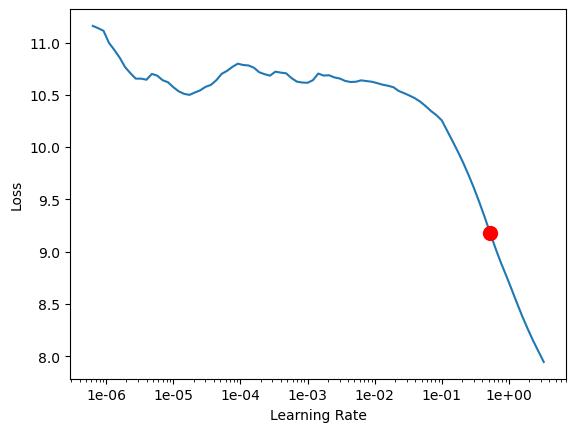

In [137]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [138]:
lr = 1e-2
lr *= bs/24

In [140]:
learner.fit_one_cycle(20, lr*10, moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time
0,1.606358,1.248927,0.612930,02:06
1,1.637919,1.267372,0.588103,02:11
2,1.641737,1.287396,0.590301,02:10
3,1.914012,1.876597,0.394408,02:10
4,1.696607,1.364697,0.574498,02:09
5,1.693828,1.339946,0.574012,02:09
6,1.693182,1.408083,0.539180,02:09
7,1.855908,1.538882,0.498030,02:09
8,1.673076,1.332362,0.574325,02:09
9,1.648234,1.277179,0.608276,02:09


In [141]:
learner.unfreeze() # The model was frozen before, meaning that the weights could not be trained. So we have to unfreeze it.
learner.fit_one_cycle(25, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.676717,0.513500,0.800117,03:08
1,0.606581,0.484917,0.810234,03:10
2,0.668911,0.535938,0.792506,03:08
3,0.701499,0.539168,0.794448,03:05
4,0.701171,0.534783,0.793348,03:04
5,0.651435,0.507281,0.803270,03:03
6,0.655598,0.502299,0.802188,03:03
7,0.616386,0.490317,0.808125,03:04
8,0.627030,0.489269,0.808449,03:04
9,0.644483,0.499935,0.806596,03:04


We have trained a task-specific MSPM, which should be mor adequate and better reflect the distribution in our task-specific chemical space. It achives an accuracy of 0.833, which does not seem bad. All the weights must be saved for all layers. However, the architecture is not saved. Therefore,we will have to define the same architecture in order to use these weights again.
We also [save the encoder](https://fastai1.fast.ai/text.learner.html) in the model folder inside the model directory.   

In [142]:
learner.save(f'{name}_MSPM_finetuned')
learner.save_encoder(f'{name}_MSPM_finetuned_enc')